In [1]:
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from PIL import Image

Using TensorFlow backend.


# Load and Process Images

In [2]:
path = "../data/RGB/Citrus"

In [3]:
imgs = []

path_07_13 = os.path.join(path, "2017-07-13")
for img_path in sorted(os.listdir(path_07_13)):
    img_path = os.path.join(path_07_13, img_path)
    imgs.append(Image.open(img_path).resize((800, 600), PIL.Image.ANTIALIAS))
    
path_08_03 = os.path.join(path, "2017-08-03")
for img_path in sorted(os.listdir(path_08_03)):
    img_path = os.path.join(path_08_03, img_path)
    imgs.append(Image.open(img_path).resize((800, 600), PIL.Image.ANTIALIAS))

In [4]:
imgs = [img.crop((200, 100, 600, 500)) for img in imgs]

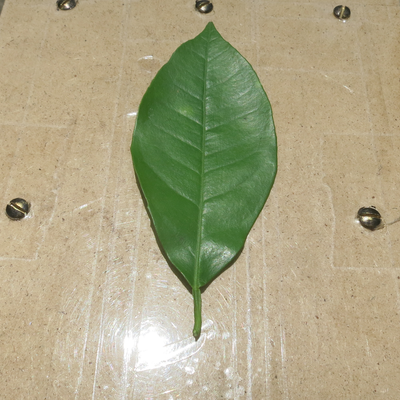

In [5]:
imgs[0]

# Load NDVI and SPAD

In [40]:
df_07_13 = pd.read_csv("../data/Spreadsheet/2017-07-13.csv")
df_08_03 = pd.read_csv("../data/Spreadsheet/2017-08-03.csv")

In [82]:
ndvi = df_07_13["NDVI"].as_matrix()
spad = df_07_13["SPAD"].as_matrix()
ndvi = np.concatenate((ndvi, df_08_03["NDVI"].as_matrix()))
spad = np.concatenate((spad, df_08_03["SPAD"].as_matrix()))

#### Since we are missing IMG_0014 in 07/13, we drop it from NDVI and SPAD

In [83]:
ndvi = np.delete(ndvi, 13)
spad = np.delete(spad, 13)
len(ndvi), len(spad)

(29, 29)

# Extract VGG Features

In [9]:
def preprocess(img):
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

In [118]:
vgg = VGG16(include_top=False)
layer = vgg.get_layer("block5_conv1").output
model = Model(inputs=vgg.inputs, outputs=layer)

In [119]:
def gram_matrix(x):
    features = x.reshape(-1, x.shape[-1])
    features = np.moveaxis(features, -1, 0)
    return np.dot(features, features.T / x.size)

In [120]:
feats = []
for img in imgs:
    feats.append(model.predict(preprocess(img)).squeeze())
feats[0].shape

(25, 25, 512)

In [121]:
flat_feats = []
for feat in feats:
    flat_feats.append(feat.flatten())
flat_feats[0].shape

(320000,)

In [122]:
gram_feats = []
for feat in feats:
    gram_feats.append(gram_matrix(feat).flatten())
gram_feats[0].shape

(262144,)

# Train Classifier on Features

In [108]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [84]:
ndvi = ndvi * 10
ndvi = np.round(ndvi)
ndvi

array([ 7.,  8.,  9.,  9.,  9.,  9.,  8.,  3.,  4.,  8.,  5.,  3.,  6.,
        9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  8.,  8.,  3.,  4.,  5.,
        8.,  8.,  5.])

In [85]:
spad = spad / 10
spad = np.round(spad)
spad

array([ 5.,  7.,  8.,  7.,  6.,  7.,  7.,  1.,  1.,  3.,  1.,  1.,  2.,
        7.,  6.,  6.,  8.,  8.,  6.,  8.,  7.,  2.,  3.,  0.,  2.,  1.,
        3.,  2.,  1.])

In [153]:
X_train, X_valid, y_train, y_valid = train_test_split(flat_feats, spad, test_size=0.15)

In [154]:
clf = RandomForestClassifier()
# clf = LogisticRegression()
clf.fit(X_train, y_train)
accuracy_score(clf.predict(X_train), y_train)

0.95833333333333337

In [155]:
accuracy_score(clf.predict(X_valid), y_valid)

0.0

In [156]:
clf.predict(X_valid)

array([ 7.,  1.,  7.,  1.,  2.])

In [157]:
y_valid

array([ 6.,  6.,  8.,  0.,  3.])